In [1]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
EPS = 1e-15
MAX_LOGSTD = 10

class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj



class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :oenbj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)



class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(VGAE, self).__init__(encoder, decoder)

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

In [2]:
import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE

import scipy.sparse as sp
import numpy as np
import networkx as nx

class SimuData():
    """Simulate graph data"""
    def __init__(self, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph

    def simu_adj_wgh(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)

            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5,5)

            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]

            A[:5,:5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>=0.3] = 1
            adj[adj<0.3] = 0
            adj_m_list.append(adj)    
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


transform = T.Compose([
            T.NormalizeFeatures(),
            T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,
                            split_labels=True, add_negative_train_samples=False),])

simu_graph = SimuData(n_graph=300)
dataset = simu_graph.graph_dataset()
n_node = simu_graph.n_node

out_channels = 2
num_features = n_node

model = VGAE(Encoder(num_features, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 1000

for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()
    
    for i in range(len(dataset)):
        train_data, val_data, test_data = transform(dataset[i])
        z = model.encode(train_data.x, train_data.edge_index)
        loss = model.recon_loss(z, train_data.pos_edge_label_index)
        loss = loss + (1 /num_features) * model.kl_loss()
        loss_total += loss

    loss_avg = loss_total/len(dataset)
    loss_avg.backward()
    optimizer.step()
    print(str(epoch)+str(loss_avg))

0tensor(1.7591, grad_fn=<DivBackward0>)
1tensor(1.7324, grad_fn=<DivBackward0>)
2tensor(1.6614, grad_fn=<DivBackward0>)
3tensor(1.6977, grad_fn=<DivBackward0>)
4tensor(1.5847, grad_fn=<DivBackward0>)
5tensor(1.6377, grad_fn=<DivBackward0>)
6tensor(1.6127, grad_fn=<DivBackward0>)
7tensor(1.5914, grad_fn=<DivBackward0>)
8tensor(1.5554, grad_fn=<DivBackward0>)
9tensor(1.5855, grad_fn=<DivBackward0>)
10tensor(1.5499, grad_fn=<DivBackward0>)
11tensor(1.5525, grad_fn=<DivBackward0>)
12tensor(1.5505, grad_fn=<DivBackward0>)
13tensor(1.5410, grad_fn=<DivBackward0>)
14tensor(1.5178, grad_fn=<DivBackward0>)
15tensor(1.5305, grad_fn=<DivBackward0>)
16tensor(1.5347, grad_fn=<DivBackward0>)
17tensor(1.4835, grad_fn=<DivBackward0>)
18tensor(1.5015, grad_fn=<DivBackward0>)
19tensor(1.4946, grad_fn=<DivBackward0>)
20tensor(1.4861, grad_fn=<DivBackward0>)
21tensor(1.4744, grad_fn=<DivBackward0>)
22tensor(1.4572, grad_fn=<DivBackward0>)
23tensor(1.4830, grad_fn=<DivBackward0>)
24tensor(1.4660, grad_fn=<

In [3]:
dataset[i].edge_index

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4],
        [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3, 4]])

In [ ]:
# get mu and logstd 
mu_list = []
logstd_list = []
for i in range(len(dataset)):
    train_data = dataset[i]
    mu, logstd = Encoder(n_node, out_channels)(train_data.x, train_data.edge_index)
    mu_list.append(np.asarray(mu.detach()))
    logstd_list.append(np.asarray(logstd.detach()))
        
mu_list_reshape = []
logstd_list_reshape = []
n = len(dataset)
for i in range(n):
    mu_list_reshape.append(mu_list[i].reshape((out_channels * n_node)))
    logstd_list_reshape.append(logstd_list[i].reshape((out_channels * n_node)))

In [26]:
mu_list

[]

In [8]:
data_mu

NameError: name 'data_mu' is not defined

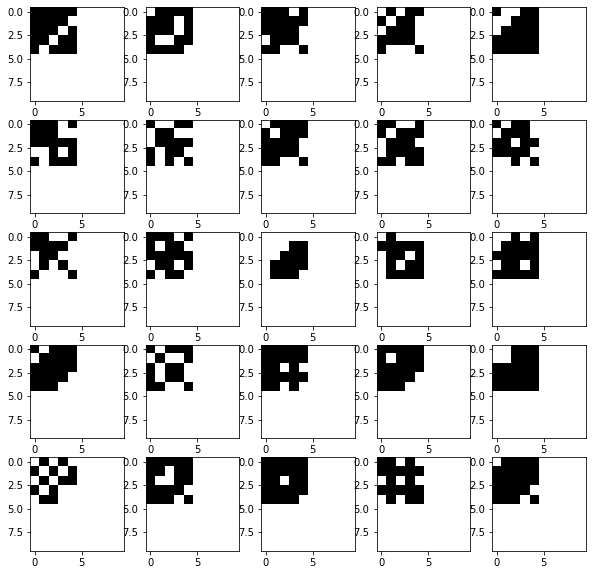

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 5, figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(simu_graph.simu_adj_m()[i], cmap="Greys")

In [10]:
import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
data_logstd = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]
    data_logstd[i, :] = logstd_list_reshape[i]

In [11]:
data_mu

array([[-0.12689967, -0.17361712, -0.13782263, ..., -0.47171333,
         0.54447311, -0.40327731],
       [-0.15907905,  0.14102031, -0.07490169, ..., -0.01416075,
        -0.05704463,  0.00565591],
       [ 0.10295992,  0.31743529,  0.15148181, ...,  0.97168303,
         0.26679745,  0.50979573],
       ...,
       [-0.26264113, -0.10327292, -0.27171719, ..., -0.04935374,
        -0.10253304,  0.01908488],
       [ 0.22839364,  0.13428517,  0.14665899, ...,  0.39562872,
        -0.12765718,  0.255088  ],
       [ 0.34333253,  0.16314252,  0.34333253, ...,  0.33048794,
         0.06805658,  0.06347208]])

In [12]:
from sklearn.mixture import GaussianMixture
gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1
gm_logstd = GaussianMixture(n_components=1, random_state=0).fit(data_logstd)
gm_logstd.weights_[0] = 1

C:\Users\Ji Qi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Ji Qi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [98]:
means_normal = gm_mu.means_
cov_normal = 10*np.eye(20)

In [94]:
cov_normal

array([[1.e-07, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 1.e-07, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 1.e-07, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 1.e-07, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-07, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-07, 0.e+00, 0.e+00,
   

In [81]:
#construct edge index
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

In [95]:
def sample_adj_mat(filter_value=0.75, filter_eye=True, noise_value=0):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal.tolist()[0],cov=cov_normal)).reshape((n_node,out_channels)))
    model.__logstd__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal.tolist()[0],cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__ + noise_value*torch.randn_like(model.__logstd__) * torch.exp(model.__logstd__)
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    adj_mat[adj_mat < filter_value] = 0
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat,model.__mu__

KeyboardInterrupt: 

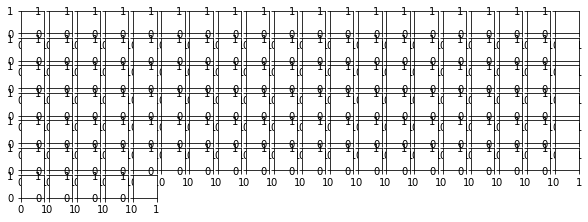

In [96]:
import matplotlib.pyplot as plt
def plot_mu_graph(mu):
    
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)
    
    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

        
plt.subplots(20, 20, figsize=(10,10))

for graph_i in range(100):
    plt.subplot(10, 10, graph_i+1)
    plot_mu_graph(mu_list[graph_i])

[[0.018514877480939416,
  0.0010066638580388417,
  0.017617184552438624,
  0.0014641244902645577,
  0.017798989681829462,
  0.0017454658490827924,
  0.01664565805833736,
  0.0013330480789674024,
  0.01755441945513192,
  0.00151317969491917,
  0.015100321117050966,
  0.0022468577106951227,
  0.013269199906525423,
  -0.0023048202749912493,
  0.017033356778141304,
  0.0010467191765297804,
  0.015518073820378307,
  0.0031756699353534972,
  0.015795683615842524,
  0.0014763418692181583],
 [0.0010066638580388417,
  0.021866900675457896,
  0.0007260048644776548,
  0.021101018280156304,
  0.0007719448569240811,
  0.021317287049019116,
  0.0013679381761190375,
  0.021391524524835778,
  0.0009351244309217809,
  0.02047775834924375,
  0.0030534777309897776,
  0.015171999754442217,
  -0.0010334641921417077,
  0.013842310559197124,
  -0.0009957471427631155,
  0.016856188309841546,
  -0.0008053067212868195,
  0.01807032358549973,
  0.003685480505144286,
  0.01891179682387707],
 [0.017617184552438624

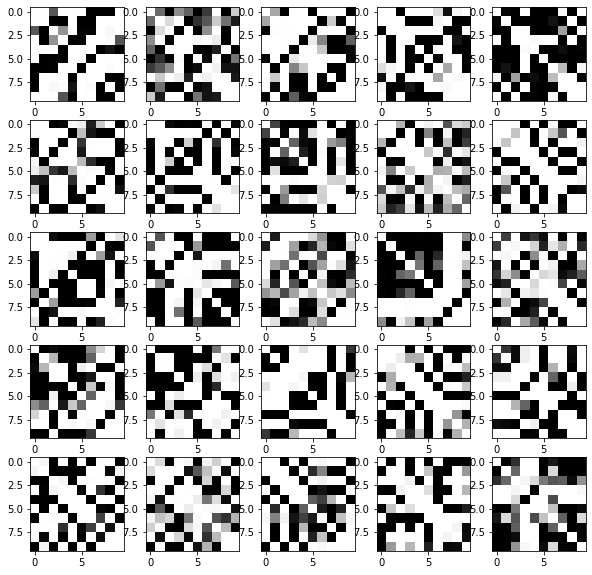

In [99]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 5, figsize=(10,10))
adj_mat_list = []
mu_list = []
for i in range(25):
    plt.subplot(5, 5, i+1)
    adj_mat, mu_sample = sample_adj_mat(filter_value=0)
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
    plt.imshow(adj_mat, cmap="Greys")

In [88]:
mu_list

[array([[ 0.05626814, -0.00551867],
        [-0.00225092,  0.02825265],
        [ 0.05643966, -0.0044625 ],
        [-0.05054395, -0.03849091],
        [-0.02404174,  0.01073013],
        [ 0.03979962,  0.02010937],
        [ 0.04530094,  0.02526812],
        [ 0.01567089,  0.04070203],
        [ 0.0939024 , -0.01712442],
        [ 0.02075483, -0.02945733]]),
 array([[ 0.02587405, -0.01615309],
        [-0.00147715, -0.06591853],
        [ 0.02393667,  0.00404381],
        [ 0.00416666, -0.02372436],
        [-0.02304084, -0.01394811],
        [ 0.01314956, -0.06130687],
        [ 0.04197949,  0.03153445],
        [ 0.0149893 , -0.0060251 ],
        [ 0.02275388, -0.00931557],
        [-0.0034889 ,  0.00663212]]),
 array([[-0.01548077, -0.00255009],
        [-0.05004364,  0.01744377],
        [-0.01229887, -0.01523119],
        [ 0.013774  , -0.03005178],
        [-0.01528239, -0.01989434],
        [ 0.01286854,  0.02838352],
        [-0.00186507, -0.00111447],
        [ 0.04790694, -0

In [85]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
np.vstack(mu_list)

array([[ 5.62681444e-02, -5.51867471e-03],
       [-2.25092066e-03,  2.82526503e-02],
       [ 5.64396637e-02, -4.46250471e-03],
       [-5.05439533e-02, -3.84909127e-02],
       [-2.40417376e-02,  1.07301254e-02],
       [ 3.97996246e-02,  2.01093745e-02],
       [ 4.53009362e-02,  2.52681155e-02],
       [ 1.56708864e-02,  4.07020314e-02],
       [ 9.39024030e-02, -1.71244224e-02],
       [ 2.07548269e-02, -2.94573317e-02],
       [ 2.58740487e-02, -1.61530911e-02],
       [-1.47715487e-03, -6.59185296e-02],
       [ 2.39366654e-02,  4.04381103e-03],
       [ 4.16666060e-03, -2.37243648e-02],
       [-2.30408361e-02, -1.39481143e-02],
       [ 1.31495583e-02, -6.13068741e-02],
       [ 4.19794914e-02,  3.15344516e-02],
       [ 1.49892990e-02, -6.02509548e-03],
       [ 2.27538781e-02, -9.31557115e-03],
       [-3.48889860e-03,  6.63212150e-03],
       [-1.54807669e-02, -2.55009314e-03],
       [-5.00436391e-02,  1.74437723e-02],
       [-1.22988675e-02, -1.52311904e-02],
       [ 1.

In [86]:
column_names = ["x", "y"]
mu_for_plot = pd.DataFrame(columns = column_names, data=np.vstack(mu_list))
mu_for_plot["label"] = list(range(10))*25

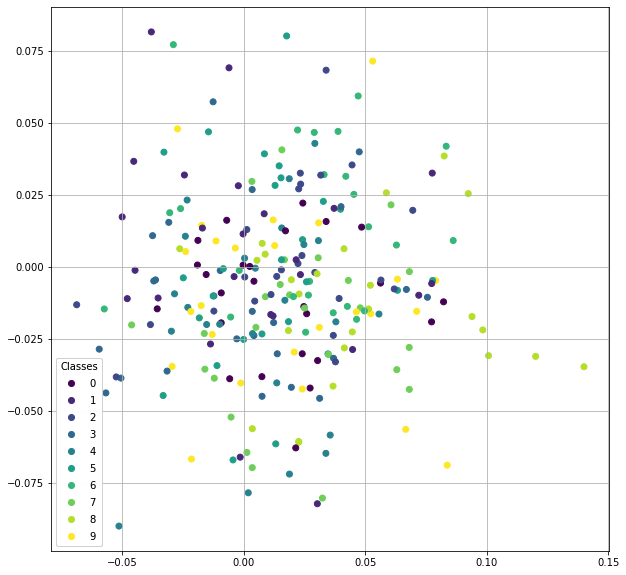

In [87]:
x = mu_for_plot["x"]
y = mu_for_plot["y"]
c = mu_for_plot["label"]
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(x, y, c=c)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

plt.grid()
plt.show()

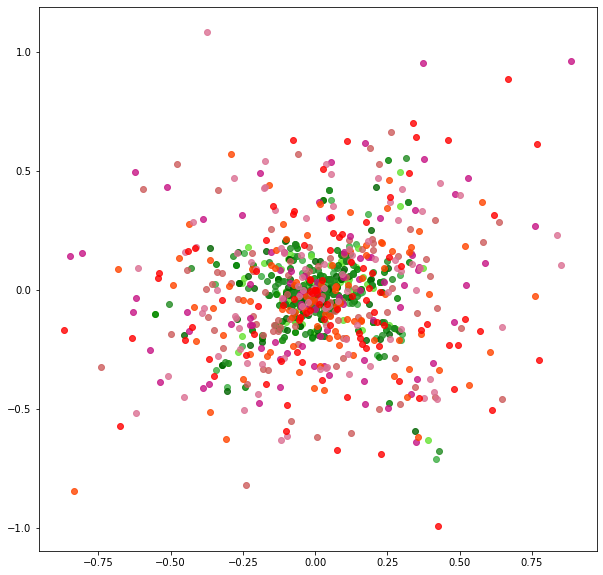

In [35]:
simu_graph = SimuData(n_graph=100)
dataset = simu_graph.graph_dataset()
n_node = simu_graph.n_node

colors = ['#3DAE43', '#67E332','#008000', '#006400', '#228B22',
          '#CD5C5C','#C71585', '#FF4500', '#DB7093', '#FF0000']
mu_list = []
logstd_list = []
for i in range(len(dataset)):
    train_data = dataset[i]
    mu, logstd = Encoder(n_node, out_channels)(train_data.x, train_data.edge_index)
    mu_list.append(np.asarray(mu.detach()))
    logstd_list.append(np.asarray(logstd.detach()))

plt.figure(figsize=(10,10))
for node_i in range(n_node):
    
    node_mu = np.empty((0, 2))
    for graph_i in range(len(mu_list)):
    
        node_mu = np.vstack((node_mu, mu_list[graph_i][node_i, :]))
    
    plt.scatter(node_mu[:,0],node_mu[:,1], c=colors[node_i],alpha=0.8)

plt.show()

In [36]:
cov_normal

array([[[ 0.01845416,  0.00100331,  0.01755846,  0.00145924,
          0.01773966,  0.00173965,  0.01659017,  0.0013286 ,
          0.0174959 ,  0.00150814,  0.01504999,  0.00223937,
          0.01322497, -0.00229714,  0.01697658,  0.00104323,
          0.01546635,  0.00316508,  0.01574303,  0.00147142],
        [ 0.00100331,  0.02179501,  0.00072358,  0.02103068,
          0.00076937,  0.02124623,  0.00136338,  0.02132022,
          0.00093201,  0.0204095 ,  0.0030433 ,  0.01512143,
         -0.00103002,  0.01379617, -0.00099243,  0.0168    ,
         -0.00080262,  0.01801009,  0.0036732 ,  0.01884876],
        [ 0.01755846,  0.00072358,  0.02061384,  0.0010805 ,
          0.01923475,  0.00169485,  0.0176391 ,  0.00088271,
          0.01909183,  0.00136725,  0.01769885,  0.00137052,
          0.01494137, -0.0029559 ,  0.01816823,  0.00147129,
          0.01529188,  0.00182076,  0.01696768,  0.00122616],
        [ 0.00145924,  0.02103068,  0.0010805 ,  0.02437902,
          0.0015038 ,